# CPS Labor Force Nonparticipation by Reason

Brian Dew, @bd_econ

Replaces CPS_PrimeLF_Contrib.ipynb

March 19, 2019

Replication using python of a very clever chart by Ernie Tedeschi (@ernietedeschi).

[Definitions](https://www.frbatlanta.org/chcs/human-capital-currents/2015/0612-measuring-labor-market-status-using-basic-data.aspx) of labor market status come from the FRB of Atlanta.

In [1]:
# Import preliminaries
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import os

os.chdir('/home/brian/Documents/CPS/data/clean/')

In [2]:
# Age and sex demographics in March 2001
filter_cols = ['AGE', 'FEMALE', 'NILFREASON', 'BASICWGT', 'MONTH']
df = (pd.read_feather('cps2001.ft', columns=filter_cols)
        .query('MONTH == 3 and 18 <= AGE <= 64'))

# Create dictionary with sex and age distribution in March 2001
dem_2001 = {}
for sex in [0, 1]:
    dfs = df[df['FEMALE'] == sex]
    age_dict = (dfs.groupby('AGE').BASICWGT.sum()
                / dfs.BASICWGT.sum()).to_dict()
    for age in age_dict.keys():
        dem_2001[(sex, age)] = age_dict[age]

In [10]:
results = pd.DataFrame()

for year in range(2000, 2020):
    annual_data = (pd.read_feather(f'cps{year}.ft', columns=filter_cols)
                     .query('18 <= AGE <= 64'))
    for month, df in annual_data.groupby('MONTH'):
    
        date = pd.to_datetime(f'{year}-{month}-01')

        dem_adj = {}
        for sex in [0, 1]:
            dfs = df[df['FEMALE'] == sex]
            age_dict = (dfs.groupby('AGE').BASICWGT.sum()
                        / dfs.BASICWGT.sum()).to_dict()
            for age in age_dict.keys():
                dem_adj[(sex, age)] = dem_2001[(sex, age)] / age_dict[age]

        df['COMBO'] = list(zip(df['FEMALE'], df['AGE']))
        df['ADJWGT'] = df['COMBO'].map(dem_adj) * df['BASICWGT']

        s = df.groupby('NILFREASON').ADJWGT.sum() / df.ADJWGT.sum()
        unadj = (df.groupby('NILFREASON').BASICWGT.sum()
                 / df.BASICWGT.sum()).nan
        monthly_result = s.to_frame(name=date).T
        monthly_result.at[date, 'nan'] = s.nan - unadj

        results = results.append(monthly_result)

results = results.rename({'nan': 'Demographics'}, axis=1).rolling(12).mean()
results = results.dropna().loc['2001-03-01':] * 100
final = results.iloc[0] - results

In [11]:
final = results.iloc[0] - results

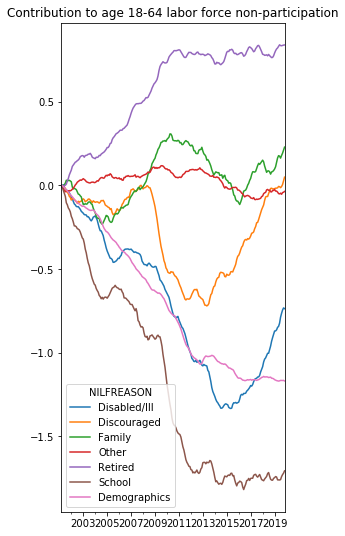

In [12]:
%matplotlib inline
title='Contribution to age 18-64 labor force non-participation'
final.plot(figsize=(4, 9), title=title);

In [ ]:
text = (f'From March 2001 to the latest available month, {ltdate}, '+
        f'an additional X.X percent of the age 18--64 population '+
        f'left the labor force. The larger-than-normal population '+
        f'cohort born after World War II reached retirement age in '+
        'this period, such age and sex-related effects explains '+
        f'X.X percent of the cumulative decrease. Additionally, '+
        f'young people are staying in school longer, on average, '+
        f'reducing the age 18--64 labor force by X.X percent. '+
        f'Disability or illness reduced the labor force by '+
        f'another X.X percent. Less retirement among those age '+
        f'18--64 increased the labor force by X.X percent.')

In [24]:
import statsmodels.api as sm
import os
os.environ['X13PATH'] = '/home/brian/Documents/econ_data/micro/x13as/'

from statsmodels.tsa.x13 import (_find_x12, x13_arima_select_order,
                                 x13_arima_analysis)

In [30]:
results

NILFREASON,Disabled/Ill,Discouraged,Family,Other,Retired,School,Demographics
2001-03-01,4.676931,1.670779,6.602101,0.896027,3.945603,3.192942,0.000003
2001-04-01,4.763601,1.780679,6.782579,0.905166,3.982152,3.239288,-0.007435
2001-05-01,4.816829,1.964508,6.795144,1.162357,4.011337,2.811613,0.017596
2001-06-01,4.944262,1.918885,6.916299,1.189014,4.046835,2.140199,0.054247
2001-07-01,4.975918,1.856202,7.003019,1.285915,4.063213,1.963876,0.037249
...,...,...,...,...,...,...,...
2019-06-01,5.645612,1.919298,6.778368,1.224289,3.169154,3.539497,1.215922
2019-07-01,5.453405,1.834392,6.901744,1.270532,3.222154,3.464521,1.203592
2019-08-01,5.363089,1.829650,6.578280,1.209097,3.308403,4.188409,1.141848
2019-09-01,5.443591,1.590780,6.432716,0.892988,3.220490,4.786163,1.095222


In [ ]:
	\thickline{green!80!blue}{date}{Disabled/Ill}{data/nilf.csv}
	\thickline{blue}{date}{Discouraged}{data/nilf.csv}
	\thickline{red}{date}{Family}{data/nilf.csv}
	\thickline{orange}{date}{Retired}{data/nilf.csv}
	\thickline{cyan}{date}{School}{data/nilf.csv}

In [13]:
subset = ['Disabled/Ill', 'Discouraged', 'Family', 'Retired', 'School']

file = '/home/brian/Documents/uschartbook/chartbook/data/nilf.csv'

final[subset].to_csv(file, index_label='date')

In [14]:
colors = {'Disabled/Ill': 'green!80!blue', 'Discouraged': 'blue', 'Family': 'red', 
          'Retired': 'orange', 'School': 'cyan'}

In [15]:
date = results.index[-1].strftime('%Y-%m-%d')

myfile = open('/home/brian/Documents/uschartbook/chartbook/text/nilf_nodes.txt', 'w')

for name, color in colors.items():
    
    val = final[name].iloc[-1]
    
    valtext = f'{val:.1f}'

    text2 = (f'\\node[label={{0:{{\\footnotesize {valtext}}}}}, circle, {color}, fill, inner sep=1.35pt] at'+
             f'(axis cs:{date}, {val}) {{}};')

    myfile.write(text2)
    
myfile.close()

In [ ]:
myfile = open('/home/brian/Documents/uschartbook/chartbook/text/nilf_nodes.txt', 'w')
for line in lines:

    myfile.write(text2)

myfile.close()